# ISMI2018 Lymphocyte Detection Project
This is the main notebook for the final ISMI2018 project by Group 6.


*Detection of lymphocytes in histopathology whole-slide images of breast, colon and prostate cancer, stained with immunohistochemistry*

### Team 6
Our group consists out of four people:
* **Brian Westerweel (Data Science)** - `B.Westerweel@student.ru.nl`
* **Christoph Schmidl (Data Science)** - `c.schmidl@student.ru.nl`
* **Gijs van der Meijde (Software Science)** - `G.vanderMeijde@student.ru.nl`
* **Jeffrey Luppes (Data Science)** - `J.Luppes@student.ru.nl`

*Supervisor: Francesco Ciompi*

Group Github page: https://github.com/jeffluppes/ISMI2018 *feel free to work in branches.*

* ```x``` = unavailable this date (e.g. unable to work on anything)
* ```-``` = reduced availability (e.g. you might be able to skype or work a couple of hours)

| Name  | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | *Notes* |
|-------|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---------|
| Jeff  | - | - | x | x | x |  - |  - |  - |  - |    |  - |    |    |    |    |    |    |    |  x |    |    | *2 hrs a day for pet projects during work days, internship ends 15th* |
| Gijs  | x | x | x | x | x |  x |  x |  x |  x |  x |  - |    |    |  - |  - |    |  - |    |    |    |    | *has short term deadline until the 14th*        |
| Brian |   |   |   | - | - |  x |  x |  - |  - |  - |  - |  x |  x |  - |  - |  - |  - | x  |  x |  x |    |         |
| Chris |   |   |   |   |   |    |  x |  x |  x |  x |    |    |    |    |  x |  x |  x |    |    |    |    |         | 


## Goals for this week (June 11 to June 18)

**MAIN GOALS**
* Use all of the training and validation data that we have available
* ~~Implement a function to return the coordinates of a mask (centroid calculation)~~
* Saving predictions (images) to disk
* ~~Make a submission file~~
* Use generator and make sensible augmentations
* Make annotations with open source tools 
* Make our first submission

**Other goals:**

* Implement loss plotting function
* Implement early stopping
* Implement a custom loss function
* Run predictions on the entire validation set

**Backlog and minor TODOs**
* Implement image warping
* Get data augmentation working
* Implement a function to count lymphocytes

Be aware of the following:

* **Next contact moment**: Monday at 10 skype call > New moment to be scheduled
* **Next group meeting**: Friday and Monday


## Important Deadlines

* ~~**Mid-term presentation:** June 4, 9:00 - 12:00, room 616 Huygen building~~
* **Deadline project:** 25th of june
* **Final presentation:** July 2, 9:00 - 12:00, room 616 Huygen building


## Resources
The two papers Francesco sent:

* https://openreview.net/pdf?id=rk0xLisiM
* https://openreview.net/pdf?id=S10IfW2oz

Kaggle Contest about cell detection (Data Science Bowl 2018)

* https://www.kaggle.com/c/data-science-bowl-2018

Particular Kernels of Interest (KoIs)

* https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
* https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

Other resources

* https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet
* https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6 (Christoph)
* https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM (Christoph)
* https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/ (Jeff)
* https://github.com/jocicmarko/ultrasound-nerve-segmentation (Jeff)
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ (Gijs)

### MOOCs if you have spare time to waste (I havent)
http://course.fast.ai/part2.html
http://course.fast.ai/lessons/lesson14.html

In [37]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob
import csv
import random 
from tqdm import tqdm
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2201136600 #because Pillow will whine to no end if you feed it big images. You're welcome.
import math

# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dropout, UpSampling2D, core
from keras.callbacks import ModelCheckpoint


# Other
import seaborn as sns
import skimage
import sklearn
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

## 0.1 Tracking time
This tracks the computation time for the entire notebook. See results in the last cell.


In [38]:
import time
start_time = time.time()

In [39]:
#user = 'ruc0028' # Jeffrey = True
user = 'ruc0030' # Gijs = True
#user = 'ruc0047'

## Cartesius file paths

In [40]:
train_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images'
validation_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images'
test_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/test_images'
train_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/training_annotations.csv'
validation_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_annotations.csv' #new
data_dir = 'data'
train_masks_dir = data_dir+'/train_masks'
validation_masks_dir = data_dir+'/validation_masks'
results_dir = 'Results'
circular_patch_dir = data_dir+'/patches_cir_an'
manual_patch_dir = data_dir+'/patches_man_an'
manual_masks_dir = 'manual_annotations'

num_channels = 3  #changing this breaks the entire thing but just so you know we include it as an option. 

gen_patches = False #Whether or not you want to generate new patches. Keep false to use patches stored on disk
train_patches_dir = data_dir+'/train_patches'
validation_patches_dir = data_dir+'/validation_patches'

#Globals for patches.
global_width = 512
global_height = 512
global_patch_amount = 500

In [42]:
# Create necessary folders if not exist
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
if not os.path.isdir(train_masks_dir):
    os.mkdir(train_masks_dir)
if not os.path.isdir(validation_masks_dir):
    os.mkdir(validation_masks_dir)
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
if not os.path.isdir(circular_patch_dir):
    os.mkdir(circular_patch_dir)
    os.mkdir(join(circular_patch_dir, 'grid'))
    os.mkdir(join(circular_patch_dir, 'optimal'))
    os.mkdir(join(circular_patch_dir, 'random'))
if not os.path.isdir(manual_patch_dir):
    os.mkdir(manual_patch_dir)
    os.mkdir(join(manual_patch_dir, 'grid'))
    os.mkdir(join(manual_patch_dir, 'optimal'))
    os.mkdir(join(manual_patch_dir, 'random'))
if not os.path.isdir(join(manual_masks_dir)):
    os.mkdir(manual_masks_dir)
if not os.path.isdir(train_patches_dir):
    os.mkdir(train_patches_dir)
if not os.path.isdir(validation_patches_dir):
    os.mkdir(validation_patches_dir)

In [43]:
# read in train csv and show what we've got
train_annotations = pd.read_csv(train_points, index_col=False)
train_annotations.describe()

,roi_id,pixel_size,x,y,score
count,50811.000000,50811.000000,50811.000000,50811.000000,50811.0
mean,3.810966,0.237240,1896.588442,1407.527356,1.0
std,2.654371,0.026024,1688.602631,1286.433055,0.0
min,1.000000,0.121547,3.398438,4.304688,1.0
25%,2.000000,0.243094,744.808594,574.351562,1.0
50%,3.000000,0.243094,1435.830078,1067.398438,1.0
75%,5.000000,0.243094,2549.500000,1872.800781,1.0
max,23.000000,0.243094,15101.097656,14209.000000,1.0


In [44]:
train_annotations[' pixel_size'].describe()

count    50811.000000
mean         0.237240
std          0.026024
min          0.121547
25%          0.243094
50%          0.243094
75%          0.243094
max          0.243094
Name:  pixel_size, dtype: float64

**What to gather from this?**

We have 50811 points, the pixel sizes vary from 0.12 to 0.24 but the mean is much closer to 0.24 indicating a skewed distribution. Yet, it's good to keep in mind the varying sizes!

### Some statistics on the training data
So the annotations file has the locations of each annotated cell. It would be good to know how many lymphocytes per ROI we can expect. The below query produces an ordered list per image and ROI of how many annotations we have per combination.

In [45]:
# get annotations per image, bear in mind this only actually obtains the ROIs that have lymphocytes
# note: this specifically returns a dataframe instead of a series so we can plot it with ease
df = train_annotations.groupby([' roi_id','image_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df.index.name = 'Combination_id'
df.head(10)

,roi_id,image_id,counts
Combination_id,,,
33,1,T3C02L1A1B1S11R01,2052
133,4,T1C02L1A1B1S11R01,1258
78,3,35_CD8,1045
16,1,95-30827-5_CD3,905
9,1,37_CD3,842
89,3,T10-4360_I_AG_CD3,804
66,2,T2C02L1A1B1S11R01,799
107,4,12-CD3_27.11.2014_17.27.31,789
22,1,T17-071549_III5_CD3,749


## If the jupyter server runs locally (Brian, Gijs)

In [46]:
#ttrain_dir = 'train_images'
#ttrain_masks_dir = 'train_masks'
#train_points = 'training_annotations.csv'

# Part 1 - Housekeeping
This section defines the convenience methods needed for processing the images.

* Creating various masks (used as ground truth)
    * Square Masks
    * Elipse Masks
    * Circular Masks
    * Mask creation
* Creating patches
    * Patch generation
* Data augmentation generator

In [47]:
def split(x):
    return x.split(', ')

### 1.1 Creating Masks

In [48]:
def createSquareMask(h, w, center, radius):
    mask = np.zeros((h, w), dtype=bool)
    lb = center[0] - radius
    rb = center[0] + radius
    ub = center[1] - radius
    bb = center[1] + radius
    mask[ub:bb, lb:rb] = True
    return mask

def createElipseMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + 2*(Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def createCircularMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
    

def createMaskForImage(img_dir, image_path, center_csv, mask_dir, mask_fn):
    image_name = image_path.split('.png')[0]
    image_id, roi = image_name.split('_ROI_')
    print('Processing {}'.format(image_name))
    
    image = plt.imread(join(img_dir, image_path))
    mask = np.zeros((image.shape[0], image.shape[1]))
    pixel_size = 0.24309392273426056 # is this the same for each image?
     
    radius = 3 / pixel_size #Brian's was 3.5.
    
    pois = []
    with open(center_csv) as file:
        pois = list(map(split, file.readlines()[1:]))
    
    pois = [poi for poi in pois if (poi[0] == image_id and poi[1] == roi)]

    
    print('Found {} lymphocytes in this image.'.format(len(pois))) # How many lymps are annotated here?
    for poi in pois:
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        shape_mask = mask_fn(image.shape[0], image.shape[1], [x, y], radius)
        mask[shape_mask] = 1
        
    mask_image = Image.fromarray(np.uint8(mask*255), 'L')
    mask_image.save(join(mask_dir, image_name + '_mask.png'))
    print('Created a mask for: {}'.format(image_name))

In [49]:
training_paths = os.listdir(train_dir)
mask_paths = os.listdir(train_masks_dir)
print('Found {} training images for patch generation.'.format(len(training_paths))) # How many images do we actually have?

# Go through the masks, print progress because this is a long job!
for idx, path in enumerate(training_paths):

    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        print('Currently at image {}'.format(idx))
        createMaskForImage(train_dir, path, train_points, train_masks_dir, createCircularMask)

Found 413 training images for patch generation.


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


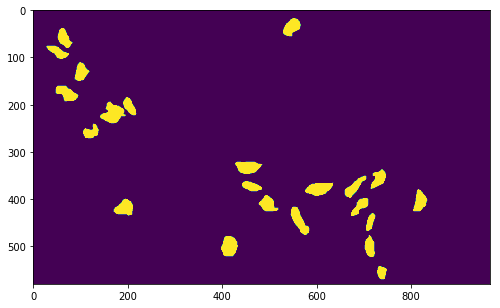

In [273]:
plt.figure(1, figsize=(18, 6))
plt.subplot(121)
_thisisatempmask = imread(join(manual_masks_dir, "4_CD3_ROI_12_mask.png"))
if len(_thisisatempmask.shape) > 2:
    _thisisatempmask = _thisisatempmask[:,:,0]
plt.imshow(_thisisatempmask)

### 1.2 Patch Generator
We experimented with multiple ways of generating patches. In this part of the Notebook the different patch generators are implemented.
Since big amounts of patches cause memmory issues we store them on the disk.

In [50]:
def storepatchesondisk(patches, dirname):
    print("Storing patches...")
    if not os.path.exists(dirname):
        print("Creating directory: ".format(dirname))
        os.system('mkdir -p ' + dirname)
    patch_nr = int(len(os.listdir(dirname))/2)
    for patch in patches:
        _mask = Image.fromarray(np.uint8(patch[1]*255), 'L')
        _img = Image.fromarray(np.uint8(patch[0]), 'RGB')
        _mask.save(join(dirname, str(patch_nr)) + '_mask.png')
        _img.save(join(dirname, str(patch_nr)) + '.png')
        patch_nr += 1
    print('Patches stored!')

def getpatchesfromdisk(dirname):
    #TODO
    return patches

In [51]:
def get_point_from_coord(coord, width, height):
    col = int(coord[0])
    col1 = col + global_width
    row = int(coord[1])
    row1 = row + global_height
    return (row, row1, col, col1)

def show_patch(img, msk, points):
    plt.figure(1, figsize=(18, 6))
    plt.subplot(121)
    plt.imshow(img[points[0]:points[1],points[2]:points[3],:])
    plt.subplot(122)
    plt.imshow(msk[points[0]:points[1],points[2]:points[3]])

In [179]:
def test_saved_patches(path):
    if os.path.isfile(path):
        img_name = path.replace("_mask", "")
    else:
        all_img_paths = os.listdir(path)
        img_name = join(path,random.sample(all_img_paths, 1)[0].split(".png")[0]).replace("_mask", "")
    print("loading {}".format(img_name))
    _img = imread(img_name+".png")
    _msk = imread(img_name+"_mask.png")

    points = (0, _img.shape[0], 0, _img.shape[1])#get_point_from_coord(coord, global_width, global_height)
    show_patch(_img, _msk, points)

#### 1.2.1 Split patches
This patch generator splits the images that have a mask into smaller images of given dementions. If the sub-image contains lymphocytes it, and its mask, will be added to the list of patches. This patch generator stops when the patch_amount is reached. if patch_amount <= 0 it will generate patches for all images that have a mask.

Example call: *generate_split_patches(train_dir, train_masks_dir, 0, global_width, global_height, train_points)*

In [173]:
def split_img_in_patches(img, msk, width, height, pois, contains_lymphos):
    if(img.shape[0] > 10000 and img.shape[1] > 10000): #fixes memmory overflow...
        print("WARNING: Image to big, skipping it!")
        return []
    horizontal_amount = math.floor(img.shape[1]/width)
    vertical_amount   = math.floor(img.shape[0]/height)
    patches = []
    print("getting {}*{}={} patches from image (dimensions:{}x{}, max-dimensions:{}x{})".format(horizontal_amount, vertical_amount, horizontal_amount*vertical_amount, img.shape[0], img.shape[1], (horizontal_amount-1)*width, (vertical_amount-1)*height))
    for i in range(0, vertical_amount-1):
        for j in range(0, horizontal_amount-1):
            row = i*height
            row1 = (i+1)*height
            col = j*width
            col1 = (j+1)*width
            lymphos = len([poi for poi in pois if (float(poi[3]) >= col and float(poi[3]) <= col1 and float(poi[4]) >= row and float(poi[4]) <= row1)])
            if( (contains_lymphos and lymphos > 0) or (not contains_lymphos and lymphos == 0)):
                print("adding patch with points:  row:{} row1:{} col:{} col1:{}   (dimensions:{}x{})".format(row,row1,col,col1, row1-row, col1-col))
                patches.append( (np.array(img[row:row1,col:col1,:]), np.array(msk[row:row1,col:col1])) )
    return patches

In [249]:
#if patch_amount <= 0 all images that have a mask will be patched!
def generate_split_patches(img_dir, msk_dir, patch_dir, patch_amount, width, height, csv_file, contains_lymphos):
    cur_patch_amount = 0;
    all_img_paths = os.listdir(img_dir)
    img_paths = random.sample(all_img_paths, patch_amount)
    with open(csv_file) as file:
        pois = list(map(split, file.readlines()[1:]))
    msk_paths = os.listdir(msk_dir)
    for msk_path in msk_paths:
        img_base_name = msk_path.split("_mask")[0]
        img_id, roi = img_base_name.split('_ROI_')
        _pois = [poi for poi in pois if (poi[0] == img_id and poi[1] == roi)]
        print("patching {}".format(img_base_name+".png"))
        msk = imread(join(msk_dir,img_base_name+"_mask.png"))
        if len(msk.shape) > 2:
            msk = msk[:,:,0]
        patches = split_img_in_patches(imread(join(img_dir,img_base_name+".png")), msk, width, height, _pois, contains_lymphos)
        print("Finished splitting {}".format(img_base_name))
        cur_patch_amount += len(patches)
        a = cur_patch_amount - patch_amount if (patch_amount > 0 and cur_patch_amount>=patch_amount) else len(patches)
        storepatchesondisk(patches[:a], patch_dir)
        if(patch_amount > 0 and cur_patch_amount>=patch_amount):
            print("Gathered enough patches...")
            break
    print("FINISHED PATCHING")
    #return patches if (patch_amount < 1) else patches[:patch_amount]

#_temp_patch_amount = math.floor(global_patch_amount*0.75)
#generate_split_patches(train_dir, train_masks_dir, circular_patch_dir, _temp_patch_amount, global_width, global_height, train_points, True)
#generate_split_patches(train_dir, train_masks_dir, circular_patch_dir, global_patch_amount-_temp_patch_amount, global_width, global_height, train_points, True)
#generate_split_patches(train_dir, train_masks_dir, circular_patch_dir+"/grid", 0, global_width, global_height, train_points, True)
#generate_split_patches(train_dir, train_masks_dir, circular_patch_dir+"/grid", 0, global_width, global_height, train_points, False)

#### 1.2.2 'Best' patches
This patch generator checks the .csv file for the patch (of given dimensions) on an image that contains the most lymphocytes.
This patch, and its mask, will be added to the list of patches. This patch generator is 'embedded' in the next patch generator and can be called by toggling the last boolean parameter to True.

Example call: *generate_patches(train_dir, train_masks_dir, 300, global_width, global_height, train_points, True)*

In [54]:
def get_best_patch_coordinate(csv_file, img_id, roi, width, height):
    best_x_coord = 0
    best_y_coord = 0
    with open(csv_file) as file:
        pois = list(map(split, file.readlines()[1:]))
    pois = [poi for poi in pois if (poi[0] == img_id and poi[1] == roi)]
    best_x_coord = get_best_from_column(pois, width, 3)
    pois = [poi for poi in pois if (float(poi[3]) >= best_x_coord and float(poi[3]) <= best_x_coord + width)]
    best_y_coord = get_best_from_column(pois, height, 4)
    print("Best coordinate for {}_ROI_{} is {}X{}".format(img_id, roi, int(best_x_coord), int(best_y_coord)))
    return (best_x_coord, best_y_coord)
    
def get_best_from_column(pois, length, column):
    best_coord = 0
    best_amount = 0
    for i in range(0, len(pois)):
        cur_coord = float(pois[i][column])
        cur_amount = len([poi for poi in pois if (float(poi[column]) >= cur_coord and float(poi[column]) <= cur_coord + length)])
        if(cur_amount > best_amount):
            best_coord = cur_coord
            best_amount = cur_amount
    print("best index on column {} is {}  ({} results)".format(column, best_coord, best_amount))
    return best_coord 

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


best index on column 3 is 23.921875  (61 results)
best index on column 4 is 38.28125  (61 results)
Best coordinate for T2C03L1A2B1S11R01_ROI_9 is 23X38


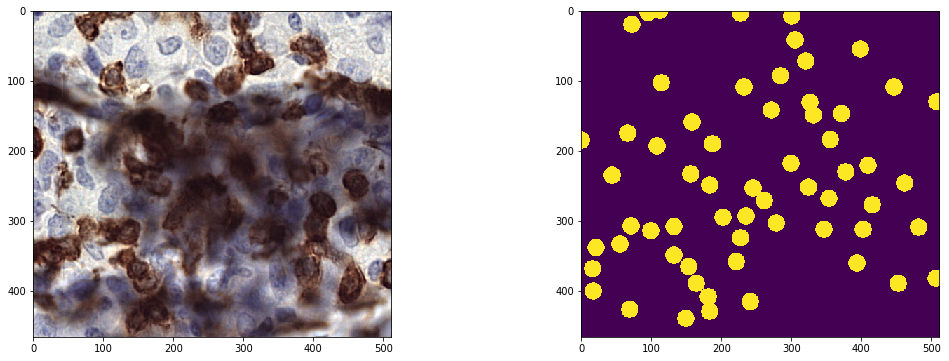

In [128]:
#TESTING get_best_patch_coordinate function
def test_get_best_patch_coordinate():
    all_img_paths = os.listdir(train_dir)
    img_name = random.choice(all_img_paths).split(".png")[0]
    #img_name = "31_CD3_ROI_8"
    img_id, roi = img_name.split('_ROI_')
    _img = imread(join(train_dir,img_name+".png"))
    _msk = imread(join(train_masks_dir,img_name+"_mask.png"))
    coord = get_best_patch_coordinate(train_points, img_id, roi, global_width, global_height)
    points = get_point_from_coord(coord, global_width, global_height)
    show_patch(_img, _msk, points)
    
test_get_best_patch_coordinate()

#### 1.2.3 Random patches
This patch generator generates random patches that contain at least 1 lymphocyte. Duplicate patches should not occur.
To use random patch generation toggle the last boolean parameter to False.

Example call: *generate_patches(train_dir, train_masks_dir, 300, global_width, global_height, train_points, False)*

In [56]:
patch_log = []
coord_tries = []
def get_random_patch_coordinate(csv_file, img_id, roi, width, height):
    #img_name = img_path.split('.png')[0]
    #img_id, roi = img_name.split('_ROI_')
    pois = []
    
    with open(csv_file) as file:
        pois = list(map(split, file.readlines()[1:]))
    pois = [poi for poi in pois if (poi[0] == img_id)]
    while(len(coord_tries) < len(pois)):
        #for poi in pois:
        p = random.randint(0,len(pois)-1)
        while(p in coord_tries):
            p = random.randint(0,len(pois)-1)
        coord_tries.append(p)
        poi = pois[p]
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        if( (x,y) in patch_log):
            return None
        patch_log.append( (x,y) )
        return (x, y)
    return (0, 0)

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys


Random coordinate for T17-071827_III2_CD-3_ROI_7 is 1413X644


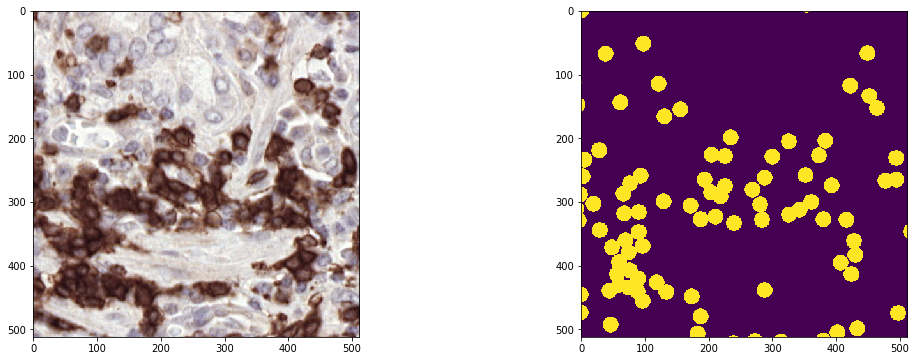

In [77]:
#TESTING get_best_random_coordinate function
def test_get_random_patch_coordinate():
    all_img_paths = os.listdir(train_dir)
    img_name = random.sample(all_img_paths, 1)[0].split(".png")[0]
    img_id, roi = img_name.split('_ROI_')
    _img = imread(join(train_dir,img_name+".png"))
    _msk = imread(join(train_masks_dir,img_name+"_mask.png"))
    coord = get_random_patch_coordinate(train_points, img_id, roi, global_width, global_height)
    print("Random coordinate for {} is {}X{}".format(img_name, int(coord[0]), int(coord[1])))
    points = get_point_from_coord(coord, global_width, global_height)
    show_patch(_img, _msk, points)
    
test_get_random_patch_coordinate()

In [248]:
#This function generates 1 random patch from patch_amount random images.

def generate_patches(img_dir, msk_dir, csv_file, patch_amount=global_patch_amount, width=global_width, height=global_height, best_patches=False):
    patches = []
    all_msk_paths = os.listdir(msk_dir)
    msk_paths = []
    for i in range(patch_amount):
        msk_paths.append(random.choice(all_msk_paths))
    
    for msk_path in msk_paths:
        img_name = msk_path.split('_mask.png')[0]
        img_path = img_name + '.png'
        img = imread(join(img_dir, img_path))
        msk = imread(join(msk_dir, msk_path))

        coord = (0,0)
        img_id, roi = img_name.split('_ROI_')
        if(best_patches == True):
            coord = get_best_patch_coordinate(csv_file, img_id, roi, width, height)
        else:
            coord = get_random_patch_coordinate(csv_file, img_id, roi, width, height)
        
        if(coord != None):
            patch = generate_patch(img,msk,width,height, coord)
            patches.append(patch)
            print("{}: {}  image: {}".format(len(patches), patch[0].shape, msk_path))
    while(best_patches == False and len(patches) < patch_amount):
        print("only {} out of {} patches could be generated, recursing now".format(len(patches), patch_amount))
        np.append(patches, generate_patches(img_dir, msk_dir, patch_amount - (len(patches) -1), width, height), axis=0)
    return patches

#This function generates a single random patch from an image.
def generate_patch(img, msk, width, height, coord):
    padHeight = 0 if height < img.shape[1] else height-img.shape[1]
    padWidth  = 0 if width < img.shape[0] else width-img.shape[0]
    if len(msk.shape) > 2:
        msk = msk[:,:,0]
    if(img.shape[0] < width or img.shape[1] < height):
        print("padding: {}x{}".format(padWidth, padHeight))
    img = np.pad(img, [(0,padWidth), (0, padHeight), (0,0 )], mode='constant')
    msk = np.pad(msk, [(0,padWidth), (0, padHeight)], mode='constant')
    row, row1, col, col1 = get_point_from_coord(coord, width, height)
    if row1 > img.shape[0]:
        print("WARNING x out of bounds ({} > {}). Correcting coordinate to fit image.".format(row1,img.shape[0]))
        row1 = img.shape[0]
        row = row1 - width
    if col1 > img.shape[1]:
        print("WARNING y out of bounds ({} > {}). Correcting coordinate to fit image.".format(col1,img.shape[1]))
        col1 = img.shape[1]
        col = col1 - height
    return (np.array(img[row:row1,col:col1,:]), np.array(msk[row:row1,col:col1]))

#### 1.2.4 Patch generation
Here we generate the actual patches that are used for training

In [231]:
# random_patches = generate_patches(train_dir, train_masks_dir, train_points, global_patch_amount, global_width, global_height, False)
# storepatchesondisk(random_patches, join(circular_patch_dir, 'random'))
# optimal_patches = generate_patches(train_dir, train_masks_dir, train_points, global_patch_amount, global_width, global_height, True)
# storepatchesondisk(optimal_patches, join(circular_patch_dir, 'optimal'))
# man_random_patches = generate_patches(train_dir, manual_masks_dir, train_points, global_patch_amount, global_width, global_height, False)
# storepatchesondisk(man_random_patches, join(manual_patch_dir, 'random'))
# man_optimal_patches = generate_patches(train_dir, manual_masks_dir, train_points, global_patch_amount, global_width, global_height, True)
# storepatchesondisk(man_optimal_patches, join(manual_patch_dir, 'optimal'))
#generate_split_patches(train_dir, train_masks_dir, join(circular_patch_dir, "grid"), 0, global_width, global_height, train_points, True)
#generate_split_patches(train_dir, train_masks_dir, join(circular_patch_dir, "grid"), 0, global_width, global_height, train_points, False)
generate_split_patches(train_dir, manual_masks_dir, join(manual_patch_dir, 'grid'), 0, global_width, global_height, train_points, True)
generate_split_patches(train_dir, manual_masks_dir, join(manual_patch_dir, 'grid'), 0, global_width, global_height, train_points, False)


patching 95-00909-II-L1_CD8_ROI_11.png
getting 1*0=0 patches from image (dimensions:390x518, max-dimensions:512x0)
Finished splitting 95-00909-II-L1_CD8_ROI_11
Storing patches...
Patches stored!
patching T2C03L1A2B1S11R01_ROI_12.png
getting 2*1=2 patches from image (dimensions:864x1216, max-dimensions:1024x512)
Finished splitting T2C03L1A2B1S11R01_ROI_12
Storing patches...
Patches stored!
patching 3_CD8_ROI_6.png


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


getting 25*15=375 patches from image (dimensions:7742x13092, max-dimensions:12800x7680)
adding patch with points:  row:0 row1:512 col:10752 col1:11264
adding patch with points:  row:512 row1:1024 col:9728 col1:10240
adding patch with points:  row:1024 row1:1536 col:512 col1:1024
adding patch with points:  row:1024 row1:1536 col:1024 col1:1536
adding patch with points:  row:2048 row1:2560 col:3584 col1:4096
adding patch with points:  row:2048 row1:2560 col:6144 col1:6656
adding patch with points:  row:2048 row1:2560 col:9216 col1:9728
adding patch with points:  row:2048 row1:2560 col:11776 col1:12288
adding patch with points:  row:2560 row1:3072 col:1024 col1:1536
adding patch with points:  row:2560 row1:3072 col:6656 col1:7168
adding patch with points:  row:3072 row1:3584 col:6144 col1:6656
adding patch with points:  row:3584 row1:4096 col:1536 col1:2048
adding patch with points:  row:3584 row1:4096 col:5632 col1:6144
adding patch with points:  row:3584 row1:4096 col:8704 col1:9216
add

patching T1C02L1A1B1S11R01_ROI_5.png
Finished splitting T1C02L1A1B1S11R01_ROI_5
Storing patches...
Patches stored!
patching 19-CD3_ROI_3.png
getting 4*2=8 patches from image (dimensions:1511x2301, max-dimensions:2048x1024)
adding patch with points:  row:0 row1:512 col:0 col1:512
adding patch with points:  row:0 row1:512 col:512 col1:1024
adding patch with points:  row:0 row1:512 col:1024 col1:1536
Finished splitting 19-CD3_ROI_3
Storing patches...
Patches stored!
patching 13_CD8_ROI_15.png
getting 1*1=1 patches from image (dimensions:697x977, max-dimensions:512x512)
Finished splitting 13_CD8_ROI_15
Storing patches...
Patches stored!
patching 3_CD8_ROI_9.png
getting 1*1=1 patches from image (dimensions:826x727, max-dimensions:512x512)
Finished splitting 3_CD8_ROI_9
Storing patches...
Patches stored!
patching 4_CD3_ROI_12.png
getting 1*1=1 patches from image (dimensions:580x967, max-dimensions:512x512)
Finished splitting 4_CD3_ROI_12
Storing patches...
Patches stored!
patching 96-15186-C

Patches stored!
patching 28_CD8_ROI_12.png
getting 2*1=2 patches from image (dimensions:810x1241, max-dimensions:1024x512)
Finished splitting 28_CD8_ROI_12
Storing patches...
Patches stored!
patching 3_CD8_ROI_10.png
getting 2*2=4 patches from image (dimensions:1046x1510, max-dimensions:1024x1024)
Finished splitting 3_CD8_ROI_10
Storing patches...
Patches stored!
patching 4_CD3_ROI_10.png
getting 4*2=8 patches from image (dimensions:1392x2113, max-dimensions:2048x1024)
adding patch with points:  row:0 row1:512 col:0 col1:512
adding patch with points:  row:0 row1:512 col:512 col1:1024
adding patch with points:  row:0 row1:512 col:1024 col1:1536
Finished splitting 4_CD3_ROI_10
Storing patches...
Patches stored!
patching 2-CD3_ROI_8.png
getting 1*1=1 patches from image (dimensions:542x695, max-dimensions:512x512)
Finished splitting 2-CD3_ROI_8
Storing patches...
Patches stored!
patching 96-10846-G_CD3_ROI_2.png
Finished splitting 96-10846-G_CD3_ROI_2
Storing patches...
Patches stored!
pat

Patches stored!
FINISHED PATCHING


loading data/patches_cir_an/optimal/170


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


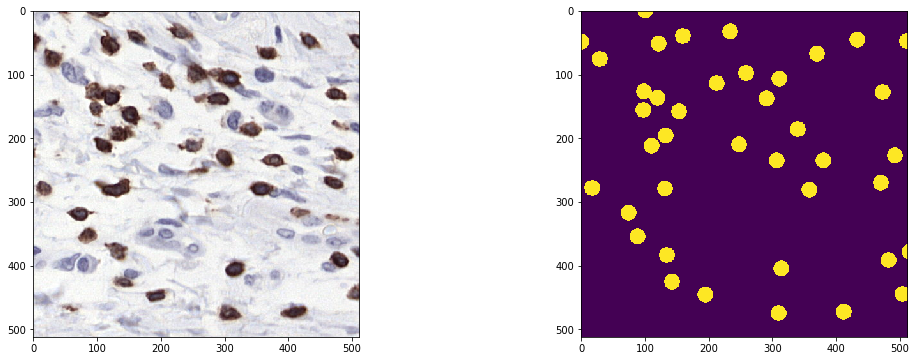

In [251]:
test_saved_patches(join(circular_patch_dir,"optimal"))

loading data/patches_cir_an/random/159


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


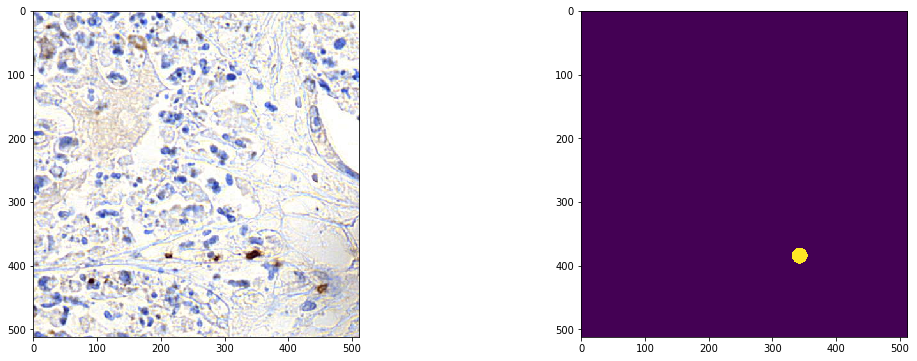

In [252]:
test_saved_patches(join(circular_patch_dir,"random"))

loading data/patches_cir_an/grid/27


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


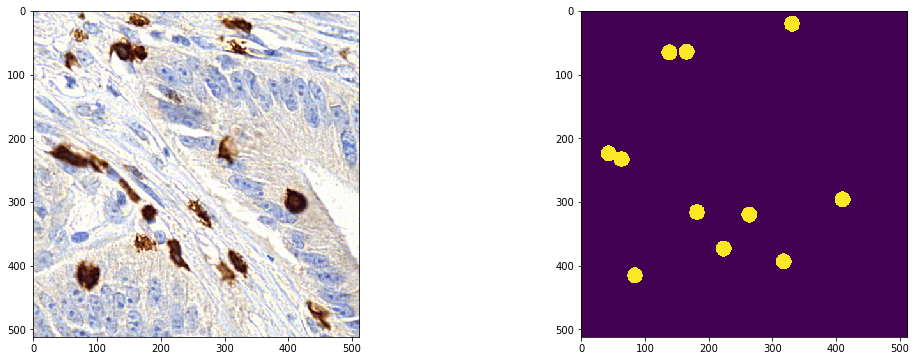

In [253]:
test_saved_patches(join(circular_patch_dir,"grid"))

loading data/patches_man_an/grid/119


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


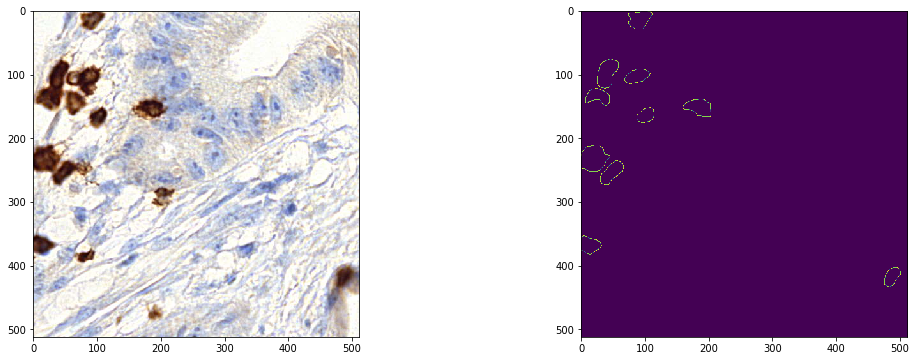

In [256]:
test_saved_patches(join(manual_patch_dir,"grid"))

#### 1.2.5 Load patches in memmory
This loads patches from the disk to the notebook so they can be used for training.

In [270]:
def load_patches_from_disk(patch_dir, amount=global_patch_amount):
    patches = []
    all_img_paths = os.listdir(patch_dir)
    all_img_paths = [k for k in all_img_paths if 'mask' not in k]
    if amount > 0 :
        img_paths = random.sample(all_img_paths, amount)
    for img_path in img_paths:
        img_name = img_path.split('.png')[0]
        patches.append( (imread(join(patch_dir, img_name+'.png')), imread(join(patch_dir, img_name+'_mask.png'))) )
    return patches
    

In [271]:
#patches = generate_patches(train_dir, train_masks_dir, train_points, global_patch_amount, global_width, global_height, True)
#patches = generate_patches(train_dir, train_masks_dir, global_patch_amount, global_width, global_height, train_points, False)
patches = load_patches_from_disk(join(circular_patch_dir,"grid"))
mask_patches = []
img_patches = []
for patch in patches:
    img_patches.append(np.array(patch[0]))
    mask_patches.append(np.array(patch[1]))

print("----------------------------")
print("{} image patches generated.".format(len(img_patches)))
print("{} mask patches generated.".format(len(mask_patches)))
print("img:  {}".format(np.array(img_patches[0]).shape))
print("mask: {}".format(np.array(mask_patches[0]).shape))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


----------------------------
500 image patches generated.
500 mask patches generated.
img:  (512, 512, 3)
mask: (512, 512)


### 1.3 Data Augmentation
*Not actually used at the moment.*

Some training examples (shape (200, 200, 3)):


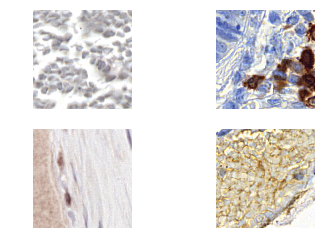

In [91]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = Image.open(input_path)
    
    
    half_the_width = image.size[0] / 2
    half_the_height = image.size[1] / 2
    image = image.crop(
        (
            half_the_width - 100,
            half_the_height - 100,
            half_the_width + 100,
            half_the_height + 100
        )
    )
    
    # Convert image to the correct range
    image = np.asarray(image) / 255

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()
    
training_paths = os.listdir(train_dir)
validation_paths = os.listdir(validation_dir)

training_images = [load_image(join(train_dir, path)) for path in training_paths[:50]]
print('Some training examples (shape {shape}):'.format(shape=training_images[0].shape))
plot_image(training_images[12:16], images_per_row=2)

In [ ]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True, 
                                     zoom_range=0.3, 
                                     width_shift_range=.3, 
                                     height_shift_range=.3)

fake_labels = np.random.rand(len(training_images))
fake_labels[fake_labels >= .5] = 1
fake_labels[fake_labels < .5] = 0

datagen.fit(training_images)

for X_batch, y_batch in datagen.flow(np.array(training_images), fake_labels, batch_size=9):
    plot_image(X_batch, images_per_row=3)
    break


## 1.5 Calulate Centroids and frame them
Calculate the centroids per blob, filter for size and extent (a measure of how stringy the blob is) and then store it in a dataframe

In [274]:
def prepareSubmissionData(image_name, images):
    # define dataframe columns
    columns = ['image_id_roi_id', 'pixel_size','x', 'y', 'score']
   
    #create the dataframe used to store coordinates
    results = pd.DataFrame(columns=columns)
    #per image get the list of centroids
    for idx, image in enumerate(images):
        
        labels = skimage.measure.label(image, background=0)
        regions = skimage.measure.regionprops(labels)
        
        #for each region found, add the data to the dataframe
        for region in regions:
            
            # only select blobs that have more than 250 pixels/voxels. Arbitrary number, needs to be optimal
            if region.area >= 250 and region.extent >= 0.6:
                
                temp = pd.DataFrame([[image_name, 0.243094, region.centroid[0], region.centroid[1], 1]], columns=columns)
                results = results.append(temp, ignore_index=True)
 
    return results

## 1.6 Metrics and loss
We use the dice coef: essentially this is another name for the f1-score. 

Additionally the mean_iou can be used as a metric. The IOU is defined as intersect over union: a useful metric to align the predicted mask with the ground truth. This allows the network to learn the edges between cells and helps to prevent the clustering cell problem where a cluster of cells is seen as the same cell. 

The IOU was used in the original U-net paper.

In [ ]:
# Custom metric
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# Define IoU metric (Credits: kaggle user cpmpml on discussion forum https://www.kaggle.com/cpmpml)
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
loss = dice_coef_loss
metrics= [dice_coef]

# Part 2 - The U-net Zoo
This is where things go deep. The following  networks are defined

* A tiny one that maxes out at 64 (tinynet)
* A "stardard" U-net that maxes out at 128 (smallnet)
* A deeper one that maxes out at 256 (mednet)
* A "stardard" U-net that maxes out at 512 (unet)
* A deeper one that maxes out at 1024 (yugenet)

Additionally this section contains the following:

* A method to save intermediate best networks
* Some sanity checks: side-by-side plot of images and masks
* Generating suitable training images
* Model compilation 
* Model training

In [287]:
def get_tinynet(img_rows=global_height, img_cols=global_width, channels=num_channels):
    inputs = Input(shape=(None, None, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    up3 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
 
    conv4 = Conv2D(1, (1, 1), activation='sigmoid')(conv3)
    model = Model(inputs=inputs, outputs=conv4)
    
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)

    return model

In [288]:
def get_smallnet(img_rows=global_height, img_cols=global_width, channels=num_channels):
    inputs = Input(shape=(None, None, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    up4 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
 
    conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    model = Model(inputs=inputs, outputs=conv6)
    
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)

    return model

In [289]:
def get_mednet(img_rows=global_height, img_cols=global_width, channels=num_channels):
    inputs = Input(shape=(None, None, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
 
    conv8 = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=conv8)
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)

    return model

In [290]:
def get_unet(img_rows=global_height, img_cols=global_width, channels=num_channels):
    # A common problem is that Keras might automatically detect "Channels first" or last. The below notation is "Channels last"
    # Which seems to be the default on cartesius. Problem, we only have once channel if we opt to only use the green channel
    #
    # Regarding input layer size - this does not seem to be our problem (Keras docs):
    # When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers,
    # does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in 
    # data_format="channels_last".
    
    # So flattening also does not force the data into our format (e.g. by using a Flatten() layer)
    
    # Our error seems to be related to https://github.com/keras-team/keras/issues/6351 which includes many miracle fixes
    # yet nothing for us.
    
    inputs = Input(shape=(None, None, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    
    sgd = keras.optimizers.SGD(lr=0.01) # Zanetta used 0.05, ours gets stuck in a local minimum and never improves. Probably related to training samples #
    # however, we are now encountering this: a never changing loss and val_loss. 
    # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)

    return model

## 2.2 An Even Deeper U-net
This one goes down to 1024.

In [291]:
def get_yugenet(img_rows=global_height, img_cols=global_width, channels=num_channels):
    # Deeper I go, deeper down
    # Didn't think it could get any
    # blacker
    # The cold bites, the pressure
    # builds
    # I think I no longer matter
    # https://www.youtube.com/watch?v=1-506_jiYkA
    
    inputs = Input(shape=(None, None, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #512
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    #1024
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
    
    #512 again
    up7 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)
 
    conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)
    model = Model(inputs=inputs, outputs=conv12)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    
    # Zanetta used a lr of 0.05, ours gets stuck in a local minimum and never improves. Probably related to training samples #
    # however, we are now encountering this: a never changing loss and val_loss. 
    # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)

    return model

Network parameters, from Francesco's paper:

* LR = 0.05
* Dropouts 0.5 (when?)
* SGD
* CCR (cross-entropy) loss
* F1-score

* RGB threshold on training imgs

Also 10 epochs with batch size 1. x20 resolution and 128x128 in- and output size 

## 2.3 F1-score
f1-score based on what we had in week 7 or 8. Not used at the moment


In [292]:
def  f1_scoref1_score(y_true, y_pred):
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    f1 = f1[~np.isnan(f1)]
    
    return f1

## 2.4 Sanity check: plotting a patch and a corresponding mask

(500, 512, 512, 3)
(500, 512, 512)


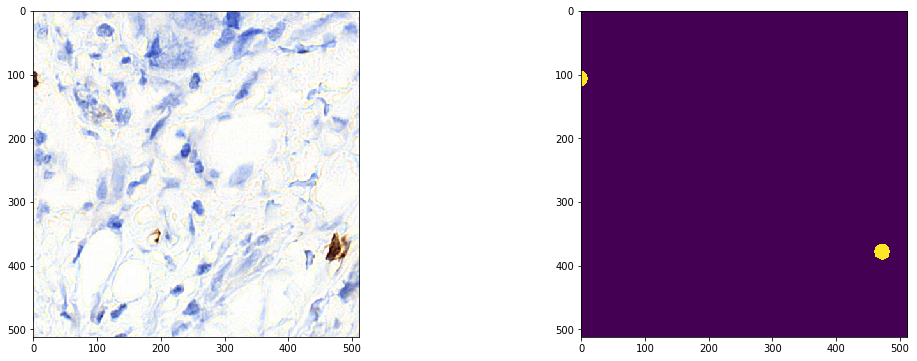

In [293]:
print(np.asarray(img_patches).shape) #should be (num_samples, 512, 512, 3)
print(np.asarray(mask_patches).shape) #should be (num_samples, 512, 512)
ino = 3

plt.figure(1, figsize=(18, 6))
# for the record, matplotlib uses this short-hand notation to show subplots. The 121 here stands for 1 row, 2 columns, first img
# now you know how to use subplots like a pro.
plt.subplot(121)
plt.imshow(img_patches[ino])

plt.subplot(122)
plt.imshow(mask_patches[ino])

## 2.5 compile model and print model architecture. 
Also defines a model_checkpoint callback.

In [294]:
model = get_unet(global_width, global_height, num_channels)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, None, None, 3 896         lambda_5[0][0]                   
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, None, None, 3 9248        conv2d_53[0][0]                  
__________________________________________________________________________________________________
max_poolin

## 2.6 Prepare X_train and y_train sets
* X_train contains the training samples (RGB)
* y_train contains the labels as a binary map. Since the masks are generated as a 3-channel image earlier on, we just need to delete the two extra channels.

In [316]:
X_train = []
y_train = []
for img in img_patches:
    #X_train.append(np.asarray(img[:, :, :]))
    X_train.append(np.asarray(img))
for msk in mask_patches:
    #y_train.append(np.asarray(msk[:, :]))
    y_train.append(np.asarray(msk))

#y_train = np.delete(y_train, 2, 3)
#y_train = np.delete(y_train, 1, 3)

#sanity checks.. what sizes are we dealing with?
print("{} patches \nX_train shape: {} \ny_train shape: {}".format(len(X_train), np.shape(X_train), np.shape(y_train)))

500 patches 
X_train shape: (500, 512, 512, 3) 
y_train shape: (500, 512, 512)


## 2.7 Plot the mask again. 

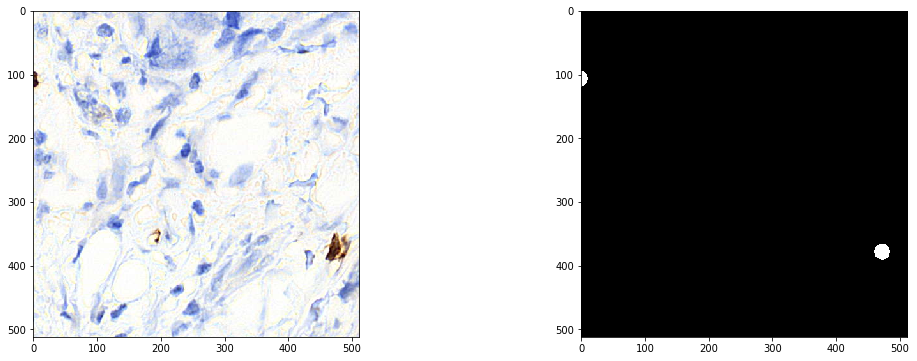

In [308]:
#intermediate level sanity checks
plt.figure(1, figsize=(18, 6))
# for the record, matplotlib uses this short-hand notation to show subplots. The 121 here stands for 1 row, 2 columns, first img
# now you know how to use subplots like a pro.
plt.subplot(121)
plt.imshow(img_patches[ino])

plt.subplot(122)
plt.imshow(np.squeeze(y_train[ino]), cmap='gray')

## 2.8 Finally train the model
Train the model. If all goes well...

In [313]:
# One epoch generally takes 1 minute with batch size 1, 200 samples. Something to keep in mind..
# the issues with the steady loss and val_loss seem to be related to the so-called dying relu problem. Go figure. Another problem to solve!
# model.fit_generator(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=10, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])
model.fit(X_train, y_train, batch_size=8, epochs=4, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 500 arrays: [array([[[126, 114, 114],
        [115,  99,  99],
        [113,  94,  90],
        ..., 
        [238, 230, 228],
        [253, 249, 246],
        [255, 254, 255]],

       [[119, 108, 106],
        ...

# Part 3 - Using the Validation set for a sanity check
The below code does the following things:

* Load the best-yet model 

* load the validation images we've been supplied with
* Generate masks for the validation images
    * Creates a validation_masks_dir if there is none yet.
    * Creates validation masks or loads them
    * Creates patches for the validation set
* Show side-by-side plots of the original validation image and the new mask

* Shove one image in our best model and ask predict() what it makes out of it
    * apply a threshold to the image
* Plot the orgininal image, the defined mask, and the prediction side-by-side

## 3.1 Load the best model

In [ ]:
# load our best model
model1 = keras.models.load_model('weights.h5') #saved by our callback earlier

## 3.2 Generate masks for the validation set

In [ ]:
# if it does not exist already, create the validation masks folder
validation_paths = os.listdir(validation_dir)
if os.path.exists(validation_masks_dir):
    pass
else:
    os.system('mkdir -p ' + validation_masks_dir)

# generate the masks if they are not already present on the system.
mask_paths = os.listdir(validation_masks_dir)

print('Found {} validation images.'.format(len(validation_paths))) # How many images do we actually have?

for idx, path in enumerate(validation_paths):
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        print('Currently at image {}'.format(idx))
        createMaskForImage(validation_dir, path, validation_points, validation_masks_dir, createCircularMask)

## 3.3 Generate patches for the validation set

In [ ]:
vpatches = generate_patches(validation_dir, validation_masks_dir, 20, global_width, global_height, validation_points, True)
vmask_patches = []
vimg_patches = []
for patch in vpatches:
    vimg_patches.append(np.array(patch[0]))
    vmask_patches.append(np.array(patch[1]))

In [ ]:
val_images_p = []
for img in vimg_patches:
    val_images_p.append(np.asarray(img[:, :, :]))
    
#sanity checks.. what sizes are we dealing with?
print(len(val_images_p))
print(np.shape(val_images_p))

## 3.4 Check patches and masks from the validation set

In [ ]:
#show validation image and it's mask - Another sanity check
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
print(vimg_patches[0].shape)
plt.imshow(vimg_patches[1])

plt.subplot(122)
plt.imshow(vmask_patches[1])

## 3.5 Make a prediction!

In [ ]:
# Make some predictions
preds_val = model1.predict(np.asarray(val_images_p), verbose=1)

## 3.6 Threshold prediction
May need to find a better way to do this at some point..

In [ ]:
print(np.amin(preds_val)) # prints min
print(np.ptp(preds_val)) # prints range
print(np.amax(preds_val)) # prints max

In [ ]:
# threshold prediction
preds_val = np.squeeze(preds_val) 
preds_val_t = (preds_val > 0.5)*1.0

In [ ]:
print(np.amin(preds_val_t)) # prints min
print(np.ptp(preds_val_t)) # prints range
print(np.amax(preds_val_t)) # prints max

## 3.7 Checking prediction output

In [ ]:
#sanity check for checking image size
print(np.shape(vimg_patches[0]))
print(np.shape(preds_val[0])) 
print(np.shape(preds_val_t[0]))

In [ ]:
# create a subplot of 1 row
plt.figure(1, figsize=(18, 6))
plt.suptitle('Example of a prediction on the validation set', fontsize=16)

idx = 1 

# plot original image
plt.subplot(151)
print(vimg_patches[idx].shape)
plt.imshow(vimg_patches[idx])
plt.title('Input data')

#plot what the mask should have been
plt.subplot(152)
print(vmask_patches[idx].shape)
plt.imshow(vmask_patches[idx])
plt.title('Actual mask')

#plot raw, unthresholded prediction
plt.subplot(153)
print(preds_val[idx].shape)
plt.imshow(preds_val[idx])
plt.title('Un-thresholded prediction')

#plot thresholded prediction
plt.subplot(154)
plt.imshow(preds_val_t[idx], cmap='gray')
plt.title('Thresholded Prediction')

#plot labels using the measure tools
from skimage.measure import label, regionprops

# what this does is label the different blobs based on the connected component principle
labels = label(preds_val_t[idx], background=0)

# it should show even the tiniest specks as different blobs, this is of course undesirable because these are false positives!
plt.subplot(155)
plt.imshow(labels, cmap='spectral')
plt.title('Identification of different clusters')

In [ ]:
#just another validation of what we're seeing
regions = regionprops(labels)

for region in regions:
    print('Number of pixels in blob: '+ format(region.area))
    print('centroid coordinates of blob: '+format(region.centroid))
    print('extent '+format(region.extent))

In [ ]:
#get full images and their titles
test_names = os.listdir(test_dir)
X_test = []
print('found:' + format(len(test_names))) # number of test images

In [ ]:
# Do a quick sample from the test set.
img = imread(join(test_dir,test_names[2]))
print(img.shape)

from sklearn import feature_extraction
img_p = feature_extraction.image.extract_patches_2d(img, (512, 512), max_patches=3)

print(img_p.shape)

In [ ]:
#show the first two pics of the test data
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
plt.title(format(test_names[0]))
plt.imshow(img_p[0])

In [ ]:
test_preds = model1.predict(img_p)

In [ ]:
#thresholding
preds_test = np.squeeze(test_preds) 
preds_test_t = (preds_test > 0.5)*1.0
print(test_preds.shape)
print(preds_test.shape)
print(preds_test_t.shape)

In [ ]:
# create a subplot of 1 row
plt.figure(1, figsize=(18, 6))
plt.suptitle('Example of a prediction on the tes set', fontsize=16)

# plot original image
plt.subplot(141)
plt.imshow(np.squeeze(img_p[0]))
plt.title('Input data')

#plot raw, unthresholded prediction
plt.subplot(142)
plt.imshow(preds_test[0])
plt.title('Un-thresholded prediction')

#plot thresholded prediction
plt.subplot(143)
plt.imshow(preds_test_t[0], cmap='gray')
plt.title('Thresholded Prediction')

# what this does is label the different blobs based on the connected component principle
labels = label(preds_test_t[0], background=0)

# it should show even the tiniest specks as different blobs, this is of course undesirable because these are false positives!
plt.subplot(144)
plt.imshow(labels, cmap='spectral')
plt.title('Identification of different clusters')

In [ ]:
#try getting the image through the prepareSubmissionData function
#preds_test_t = np.expand_dims(preds_test_t, axis=2)
df = prepareSubmissionData(test_names[1], preds_test_t)
df.head()

In [ ]:
#print to see if it looks right
df.to_csv(index=False)

In [ ]:
# make dir for results
result_dir = 'Results'
# Create directory for the results (if not already existing)
if os.path.exists(result_dir):
    pass
else:
    os.system('mkdir -p ' + result_dir)

In [ ]:
df.to_csv("file.csv", encoding="utf-8", index=False)

# Part 4 - Evaluation on the test set

## 4.1 training on the training + validation set
More data is more better. Lets take the validation set as training data for our final model and using a split of 0.1 or 0.2?

Also worth to be considered is training on full images!

## 4.2 Loading test images
TODO

## 4.3 Make predictions on the test images
TODO

## 4.4 Store test prediction images
TODO

## 4.5 Calculate Lymphocyte centroids
TODO

## 4.6 Convert predictions to a csv submission
TODO

# Part 5 - What is outside the flow of work
Counting the number of lymphocytes was the goal of the project although the evaluation is based on the precision of the network. Therefore the following method returns the number of lymphocytes, given a sample image. 

## 5.1 Counting Lymps

In [ ]:
# function to count the number of lymphocytes in a given image
def count_lymps(image):
    num = skimage.measure.label(image,  return_num=True)[1]
    return num

In [ ]:
#lets test this with a mask!
print('number of blobs: '+format(count_lymps(vmask_patches[idx])))

In [ ]:
# and other things that come up

## 5.999 Print the time needed to execute the entire notebook

In [ ]:
print("--- The entire notebook was done in %s seconds ---" % (time.time() - start_time))